# **Access Raster Data**

- Based on [this lesson](https://carpentries-incubator.github.io/geospatial-python/05-access-data/index.html)

## Imports

In [1]:
import rioxarray

## Access Cloud Optimized GeoTIFF(COGs)

### Search a STAC catalog

- Get the URL from the COG collection from [STAC Browser](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/?.language=en)

In [3]:
api_url = "https://earth-search.aws.element84.com/v1"

- Create a client of STAC catalog in our code to retrieve the data from STAC catalog

In [4]:
from pystac_client import Client

client = Client.open(api_url)

In [9]:
client

<Client id=earth-search-aws>

- Get the data collection name from the [STAC browser](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a)
  - Go to 'Source' and check the full version of the link, like this
  - <https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a>
  - We will use **sentinel-2-l2a** for collection name

In [5]:
collection = "sentinel-2-l2a"  # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)

- We also ask for scenes intersecting a geometry defined using the ``shapely`` library (in this case, a point)
- Use a X-Y coordinate pair, in this case, it's lon/lat
  - [``shapely.Point``](https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html)

In [10]:
from shapely.geometry import Point
point = Point(4.89, 52.37)  # AMS coordinates

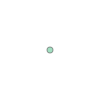

In [11]:
point

- Search for scenes that are intersect with the point just defined, return 10 items at max

In [7]:
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10,
)

- Print number of items matched our query
- We will have a lot of matched items

In [8]:
print(search.matched())

868


- Check out metadata

In [13]:
items = search.item_collection()
len(items)

10

- Print the metadata of all the items we retrieved in the search

In [14]:
for item in items:
    print(item)

<Item id=S2A_31UFU_20230711_0_L2A>
<Item id=S2B_31UFU_20230709_0_L2A>
<Item id=S2B_31UFU_20230706_0_L2A>
<Item id=S2A_31UFU_20230704_0_L2A>
<Item id=S2A_31UFU_20230701_0_L2A>
<Item id=S2B_31UFU_20230629_0_L2A>
<Item id=S2B_31UFU_20230626_0_L2A>
<Item id=S2A_31UFU_20230624_0_L2A>
<Item id=S2A_31UFU_20230621_0_L2A>
<Item id=S2B_31UFU_20230616_0_L2A>


- Print out more information in the metadata of the first item

In [15]:
item = items[0]

In [17]:
print(item.datetime)

2023-07-11 10:46:30.905000+00:00


In [23]:
item.geometry

{'type': 'Polygon',
 'coordinates': [[[5.232846700126488, 53.228701503450445],
   [4.807091071208957, 52.248723820892856],
   [6.071664488869862, 52.22257539160585],
   [6.141754296879459, 53.20819279121764],
   [5.232846700126488, 53.228701503450445]]]}

In [22]:
item.properties

{'created': '2023-07-12T13:22:11.597Z',
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 61.812901,
 'proj:epsg': 32631,
 'mgrs:utm_zone': 31,
 'mgrs:latitude_band': 'U',
 'mgrs:grid_square': 'FU',
 'grid:code': 'MGRS-31UFU',
 'view:sun_azimuth': 154.560971098787,
 'view:sun_elevation': 57.4275951463925,
 's2:degraded_msi_data_percentage': 0.0188,
 's2:nodata_pixel_percentage': 32.883963,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 5.9e-05,
 's2:cloud_shadow_percentage': 1.331609,
 's2:vegetation_percentage': 20.954552,
 's2:not_vegetated_percentage': 5.242505,
 's2:water_percentage': 10.268399,
 's2:unclassified_percentage': 0.389978,
 's2:medium_proba_clouds_percentage': 23.260967,
 's2:high_proba_clouds_percentage': 6.826783,
 's2:thin_cirrus_percentage': 31.72515,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '05.09',
 's2:product_uri': 'S2A_MSIL2A_202

### Excercise 1

- Search for all the available Sentinel-2 scenes in the sentinel-2-l2a collection that satisfy the following criteria:
- intersect a provided bounding box (use ±0.01 deg in lat/lon from the previously defined point);
- have been recorded between 20 March 2020 and 30 March 2020;
- have a cloud coverage smaller than 10% (hint: use the query input argument of client.search).

**Solution**
- Create a bounding box (``bbox``) using ``.buffer`` method of the point defined above
- It is a tuple type

- Execute a new search with the same collection, add a `bbox`, a `datetime` range, a query for cloud cover
- Documentation of the ``pystac`` library
  - [API Reference](https://pystac-client.readthedocs.io/en/stable/api.html#client)
  - [STAC API Reference 2](https://api.stacspec.org/v1.0.0-rc.2/item-search/#tag/Item-Search/operation/getItemSearch)

In [30]:
bbox = point.buffer(0.01).bounds
bbox

(4.88, 52.36, 4.8999999999999995, 52.379999999999995)

In [34]:
type(bbox)

tuple

In [37]:
search = client.search(
    collections=[collection],
    bbox=bbox,
    # intersects = point,
    datetime="2020-03-20/2020-03-30",
    query=["eo:cloud_cover<15"]
)
print(search.matched())

4


In [40]:
search.item_collection()

- Save the search results as a JSON file

In [39]:
items = search.item_collection()
items.save_object("search.json")

- JSON is a text format with a structure to conveniently retrieve information

### Access the assets

In [41]:
assets = items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [42]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

- Get the information of the thumbnail image
  - The image is saved in AWS S3

In [43]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200328_0_L2A/thumbnail.jpg


- Display the asset thumbnail image

![Picture](https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200328_0_L2A/thumbnail.jpg)

- Use ``rioxarray`` library to actually read the TIF file

In [49]:
import rioxarray
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)

In [46]:
nir

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [45]:
nir_href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/31/U/FU/2020/3/S2A_31UFU_20200328_0_L2A/B08.tif'

- Save to an external file (.tif format)

In [47]:
# save whole image to disk
nir.rio.to_raster("nir.tif")

In [48]:
# slice the image and save to a new file
nir[0,1500:2200,1500:2200].rio.to_raster("nir_subset.tif")

### Excercise 2

- Downloading Landsat 8 Assets

In [51]:
# setup the client
ls_url = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"
client = Client.open(ls_url)
client

<Client id=LPCLOUD>

In [52]:
# specify collection
collection = "HLSL30.v2.0"

In [53]:
# build a search query
search = client.search(
    collections=[collection],
    # bbox=bbox,
    intersects = Point(-73.97, 40.78),
    datetime="2021-02-01/2021-03-30"
)
search.matched()

5

In [55]:
# save the search results to items
ls_items = search.item_collection()
ls_items[0]

<Item id=HLS.L30.T18TWL.2021039T153324.v2.0>

In [79]:
# sort items by cloud cover
items_sorted = sorted(ls_items, key=lambda x: x.properties["eo:cloud_cover"])
items_sorted

[<Item id=HLS.L30.T18TWL.2021039T153324.v2.0>,
 <Item id=HLS.L30.T18TWL.2021062T153926.v2.0>,
 <Item id=HLS.L30.T18TWL.2021071T153310.v2.0>,
 <Item id=HLS.L30.T18TWL.2021078T153917.v2.0>,
 <Item id=HLS.L30.T18TWL.2021055T153318.v2.0>]

In [80]:
# print the asset names of the first item
ls_assets = items_sorted[0].assets  # first item's asset dictionary
for key, ls_assets in ls_assets.items():
    print(f"{key}: {ls_assets.title}")

B05: Download HLS.L30.T18TWL.2021039T153324.v2.0.B05.tif
B06: Download HLS.L30.T18TWL.2021039T153324.v2.0.B06.tif
B01: Download HLS.L30.T18TWL.2021039T153324.v2.0.B01.tif
B11: Download HLS.L30.T18TWL.2021039T153324.v2.0.B11.tif
B03: Download HLS.L30.T18TWL.2021039T153324.v2.0.B03.tif
Fmask: Download HLS.L30.T18TWL.2021039T153324.v2.0.Fmask.tif
B04: Download HLS.L30.T18TWL.2021039T153324.v2.0.B04.tif
VAA: Download HLS.L30.T18TWL.2021039T153324.v2.0.VAA.tif
B09: Download HLS.L30.T18TWL.2021039T153324.v2.0.B09.tif
VZA: Download HLS.L30.T18TWL.2021039T153324.v2.0.VZA.tif
B02: Download HLS.L30.T18TWL.2021039T153324.v2.0.B02.tif
SAA: Download HLS.L30.T18TWL.2021039T153324.v2.0.SAA.tif
SZA: Download HLS.L30.T18TWL.2021039T153324.v2.0.SZA.tif
B07: Download HLS.L30.T18TWL.2021039T153324.v2.0.B07.tif
B10: Download HLS.L30.T18TWL.2021039T153324.v2.0.B10.tif
browse: Download HLS.L30.T18TWL.2021039T153324.v2.0.jpg
metadata: None


In [81]:
items_sorted[0].assets

{'B05': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.B05.tif>,
 'B06': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.B06.tif>,
 'B01': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.B01.tif>,
 'B11': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.B11.tif>,
 'B03': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.B03.tif>,
 'Fmask': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L

In [83]:
# show the thumbnail image of the first item in search
print(items_sorted[0].assets["browse"].href)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.jpg


- Show the thumbnail image of LS image

![ls_items[0].id](https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSL30.020/HLS.L30.T18TWL.2021039T153324.v2.0/HLS.L30.T18TWL.2021039T153324.v2.0.jpg)